In [1]:
import keras
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
import pandas as pd 
import pandas_datareader.data as web
import datetime
import numpy as np 
from matplotlib import style

# ignore warnings 
import warnings
warnings.filterwarnings('ignore')

c:\Users\prath\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
style.use('ggplot')
data = pd.read_csv('historic_data/csv/TCS.NS.csv')
train_size = int(len(data) * 0.8) 
train_df = data[:train_size].dropna(how='any', axis=0)
test_df = data[train_size:].dropna(how='any', axis=0)


test_df.tail()



,Date,Low,Open,Volume,High,Close,Adjusted Close
5128,20-03-2023,3095.050049,3169.649902,2289468.0,3169.649902,3143.300049,3143.300049
5129,21-03-2023,3097.449951,3143.300049,1815297.0,3156.750000,3106.100098,3106.100098
5130,22-03-2023,3106.100098,3130.050049,1123939.0,3143.500000,3130.800049,3130.800049
5131,23-03-2023,3101.000000,3114.899902,1372218.0,3146.350098,3124.649902,3124.649902
5132,24-03-2023,3106.000000,3148.899902,1329577.0,3170.000000,3120.500000,3120.500000


In [3]:
train_df['Date'] = pd.to_datetime(train_df['Date'], format='%d-%m-%Y')
train_df['Date'] = train_df['Date'].dt.strftime('%Y-%m-%d')

test_df['Date'] = pd.to_datetime(test_df['Date'], format='%d-%m-%Y')
test_df['Date'] = test_df['Date'].dt.strftime('%Y-%m-%d')


#sort by date
train_df = train_df.sort_values('Date')
test_df = test_df.sort_values('Date')

# fix the date 
train_df.reset_index(inplace=True)
train_df.set_index("Date", inplace=True)
test_df.reset_index(inplace=True)
test_df.set_index("Date", inplace=True)

test_df.tail()

,index,Low,Open,Volume,High,Close,Adjusted Close
Date,,,,,,,
2023-03-20,5128,3095.050049,3169.649902,2289468.0,3169.649902,3143.300049,3143.300049
2023-03-21,5129,3097.449951,3143.300049,1815297.0,3156.750000,3106.100098,3106.100098
2023-03-22,5130,3106.100098,3130.050049,1123939.0,3143.500000,3130.800049,3130.800049
2023-03-23,5131,3101.000000,3114.899902,1372218.0,3146.350098,3124.649902,3124.649902
2023-03-24,5132,3106.000000,3148.899902,1329577.0,3170.000000,3120.500000,3120.500000


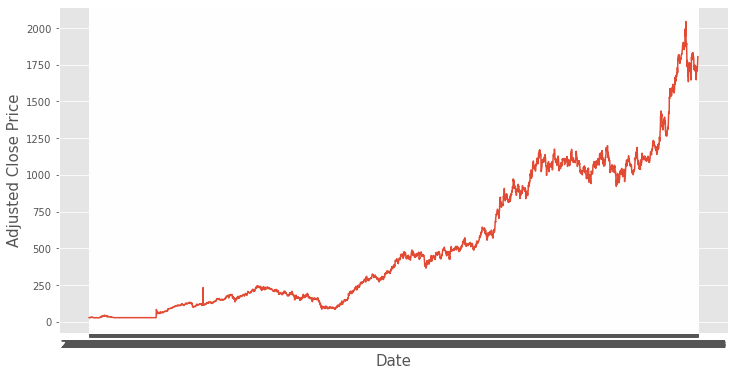

In [4]:
# Visualize the training stock data:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize = (12,6))
plt.plot(train_df["Adjusted Close"])
plt.xlabel('Date',fontsize=15)
plt.ylabel('Adjusted Close Price',fontsize=15)
plt.show()

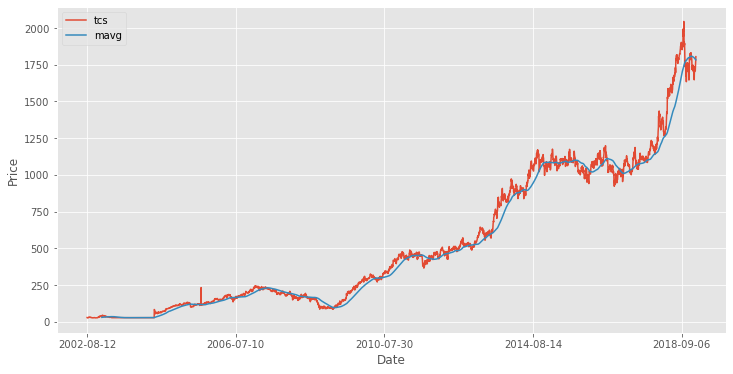

In [5]:
# Rolling mean
close_px = train_df['Adjusted Close']
mavg = close_px.rolling(window=100).mean()

plt.figure(figsize = (12,6))
close_px.plot(label='tcs')
mavg.plot(label='mavg')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()

In [6]:
import matplotlib.dates as mdates

# change the dates into ints for training 
train_dates_df = train_df.copy()
train_dates_df = train_dates_df.reset_index()

train_dates_df['Date'] = pd.to_datetime(train_dates_df['Date'])

# change the dates into ints for testing 
test_dates_df = test_df.copy()
test_dates_df = test_dates_df.reset_index()

test_dates_df['Date'] = pd.to_datetime(test_dates_df['Date'])


# Store the original dates for plotting the predicitons
train_org_dates = train_dates_df['Date']
test_org_dates = test_dates_df['Date']

# convert to ints
train_dates_df['Date'] = train_dates_df['Date'].map(mdates.date2num)
test_dates_df['Date'] = test_dates_df['Date'].map(mdates.date2num)
test_dates_df.tail()

,Date,index,Low,Open,Volume,High,Close,Adjusted Close
1022,19436.0,5128,3095.050049,3169.649902,2289468.0,3169.649902,3143.300049,3143.300049
1023,19437.0,5129,3097.449951,3143.300049,1815297.0,3156.750000,3106.100098,3106.100098
1024,19438.0,5130,3106.100098,3130.050049,1123939.0,3143.500000,3130.800049,3130.800049
1025,19439.0,5131,3101.000000,3114.899902,1372218.0,3146.350098,3124.649902,3124.649902
1026,19440.0,5132,3106.000000,3148.899902,1329577.0,3170.000000,3120.500000,3120.500000


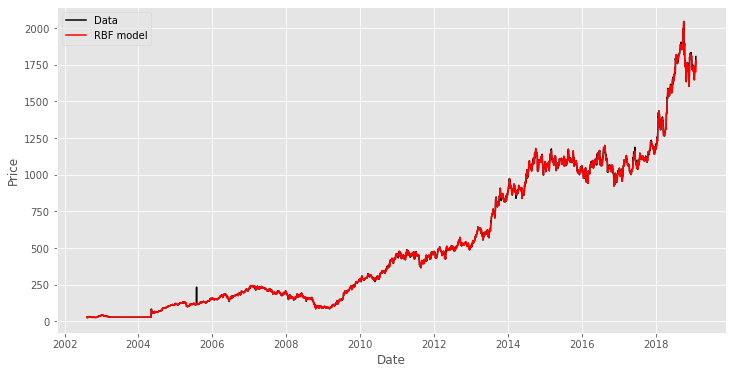

In [7]:
# Use sklearn support vector regression to predict our data:
from sklearn.svm import SVR

dates = train_dates_df['Date'].to_numpy()
prices = train_df['Adjusted Close'].to_numpy()

# Convert to 1d Vector
dates = np.reshape(dates, (len(dates), 1))
prices = np.reshape(prices, (len(prices), 1))

svr_rbf = SVR(kernel='rbf', C=1e3, gamma=0.1)
svr_rbf.fit(dates, prices)

plt.figure(figsize=(12, 6))
plt.plot(dates, prices, color='black', label='Data')
plt.plot(train_org_dates, svr_rbf.predict(dates), color='red', label='RBF model')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()


In [8]:
train_data = train_df.iloc[-1000:, train_df.columns.get_loc('Adjusted Close')].to_numpy()
print(train_data.shape)

(1000,)


In [9]:
# Apply normalization before feeding to LSTM using sklearn:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
train_data = train_data.reshape(-1,1)
# print(train_data)
scaler.fit(train_data)
train_data = scaler.transform(train_data)
print(train_data)

[[0.12321386]
 [0.11877169]
 [0.12782564]
 [0.13428186]
 [0.13166554]
 [0.12370315]
 [0.11973147]
 [0.12475721]
 [0.12466304]
 [0.12091753]
 [0.12221895]
 [0.13638323]
 [0.13828823]
 [0.11467464]
 [0.12680182]
 [0.14341845]
 [0.12683976]
 [0.14121172]
 [0.15001972]
 [0.12631143]
 [0.09924624]
 [0.10631886]
 [0.10716807]
 [0.13606236]
 [0.15343317]
 [0.17261459]
 [0.18974053]
 [0.18766569]
 [0.19562492]
 [0.19868031]
 [0.186402  ]
 [0.18046074]
 [0.18268617]
 [0.18534555]
 [0.22555685]
 [0.21424039]
 [0.19554935]
 [0.17682048]
 [0.17527386]
 [0.16163759]
 [0.16635267]
 [0.15250916]
 [0.14494625]
 [0.15301857]
 [0.14383305]
 [0.15775279]
 [0.16329739]
 [0.16563613]
 [0.15588531]
 [0.14926523]
 [0.12638711]
 [0.1270282 ]
 [0.14564377]
 [0.14179627]
 [0.13753362]
 [0.13928759]
 [0.15350884]
 [0.17478348]
 [0.18351645]
 [0.17944246]
 [0.18010236]
 [0.16963466]
 [0.15267943]
 [0.11195883]
 [0.0945878 ]
 [0.09392747]
 [0.10073631]
 [0.10531972]
 [0.11882399]
 [0.12152089]
 [0.11955968]
 [0.11

In [10]:
'''Function to create a dataset to feed into an LSTM'''
def create_dataset(dataset, look_back):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back):
        a = dataset[i:(i + look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

In [11]:
# Create the data to train our model on:
time_steps = 36
X_train, y_train = create_dataset(train_data, time_steps)
print(train_data.shape)
# reshape it [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], 36, 1))


(1000, 1)


In [12]:
# Visualizing our data with prints: 
print('X_train:')
print(str(scaler.inverse_transform(X_train[0])))
print("\n")
print('y_train: ' + str(scaler.inverse_transform(y_train[0].reshape(-1,1)))+'\n')

X_train:
[[1060.69909668]
 [1055.71203613]
 [1065.87658691]
 [1073.12475586]
 [1070.1875    ]
 [1061.24841309]
 [1056.78955078]
 [1062.4317627 ]
 [1062.3260498 ]
 [1058.12109375]
 [1059.58215332]
 [1075.48388672]
 [1077.62255859]
 [1051.11242676]
 [1064.72717285]
 [1083.38208008]
 [1064.76977539]
 [1080.90466309]
 [1090.79309082]
 [1064.17663574]
 [1033.79150391]
 [1041.73168945]
 [1042.68505859]
 [1075.12365723]
 [1094.62524414]
 [1116.1595459 ]
 [1135.38623047]
 [1133.05688477]
 [1141.99243164]
 [1145.42260742]
 [1131.63818359]
 [1124.96813965]
 [1127.46655273]
 [1130.45214844]
 [1175.59594727]
 [1162.89135742]]


y_train: [[1141.90759277]]



## Preparing our data for the neural network: 
* Here we create the 'create_dataset' function. This function loops from (0 to our dataset length - the number of time steps). 
* So essentially each index in the X_train array contains an array of 36 days of closing prices and the y_train array contains the closing price one day after our time steps. 
* So, in other words, we feed the neural network 36 days of the previous closing prices of stock data and then have it predict the next day of the closing stock price. 

In [13]:
# Build the model 
model = keras.Sequential()

model.add(LSTM(units = 100, return_sequences = True, input_shape = (X_train.shape[1], 1)))
model.add(Dropout(0.2))

model.add(LSTM(units = 100))
model.add(Dropout(0.2))

# Output layer
model.add(Dense(units = 1))

# Compiling the model
model.compile(optimizer = 'adam', loss = 'mean_squared_error')

# Fitting the model to the Training set
history = model.fit(X_train, y_train, epochs = 50, batch_size = 10, validation_split=.30)

Epoch 1/50
68/68 [==============================] - 8s 56ms/step - loss: 0.0019 - val_loss: 0.0053
Epoch 2/50
68/68 [==============================] - 3s 42ms/step - loss: 7.9472e-04 - val_loss: 0.0201
Epoch 3/50
68/68 [==============================] - 3s 39ms/step - loss: 6.7148e-04 - val_loss: 0.0017
Epoch 4/50
68/68 [==============================] - 3s 40ms/step - loss: 6.1954e-04 - val_loss: 0.0146
Epoch 5/50
68/68 [==============================] - 3s 48ms/step - loss: 6.2020e-04 - val_loss: 0.0151
Epoch 6/50
68/68 [==============================] - 3s 47ms/step - loss: 5.0017e-04 - val_loss: 0.0077
Epoch 7/50
68/68 [==============================] - 3s 47ms/step - loss: 5.6354e-04 - val_loss: 0.0042
Epoch 8/50
68/68 [==============================] - 5s 73ms/step - loss: 4.7956e-04 - val_loss: 0.0047
Epoch 9/50
68/68 [==============================] - 5s 74ms/step - loss: 4.7201e-04 - val_loss: 9.2432e-04
Epoch 10/50
68/68 [==============================] - 5s 70ms/step - loss:

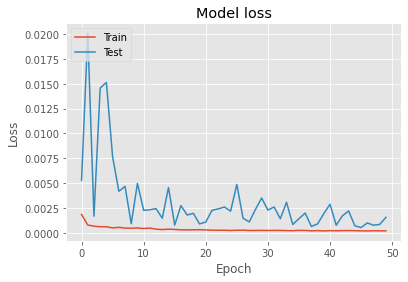

In [14]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [15]:
# Get the stock prices for 2019 to have our model make the predictions
test_data = test_df['Adjusted Close'].values
print(test_data)
test_data = test_data.reshape(-1,1)
test_data = scaler.transform(test_data)

# Create the data to test our model on:
time_steps = 36
X_test, y_test = create_dataset(test_data, time_steps)

# store the original vals for plotting the predictions 
y_test = y_test.reshape(-1,1)
org_y = scaler.inverse_transform(y_test)

# reshape it [samples, time steps, features]
X_test = np.reshape(X_test, (X_test.shape[0], 36, 1))

# Predict the prices with the model
predicted_y = model.predict(X_test)
predicted_y = scaler.inverse_transform(predicted_y)

[1804.11560059 1833.88952637 1848.3215332  ... 3130.80004883 3124.64990234
 3120.5       ]
31/31 [==============================] - 2s 25ms/step


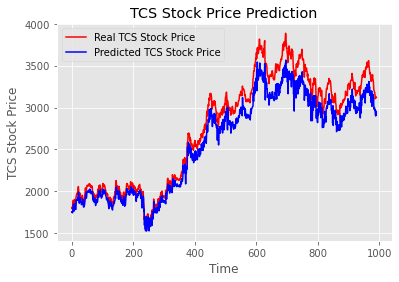

In [16]:
plt.plot(org_y, color = 'red', label = 'Real TCS Stock Price')
plt.plot(predicted_y, color = 'blue', label = 'Predicted TCS Stock Price')
plt.title('TCS Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('TCS Stock Price')

plt.legend()
plt.show()


In [17]:
# Get the latest stock price data
latest_data = data

# Extract the 'Adjusted Close' column
latest_prices = latest_data['Adjusted Close'].values

# Scale the data
latest_prices = latest_prices.reshape(-1,1)
latest_prices = scaler.transform(latest_prices)

# Reshape the data for prediction
X_today = latest_prices[-time_steps:]
X_today = np.reshape(X_today, (1, time_steps, 1))

# Predict the stock price for tomorrow
predicted_price = model.predict(X_today)
predicted_price = scaler.inverse_transform(predicted_price)

# Get the latest price for today
latest_price_today = scaler.inverse_transform(latest_prices[-1].reshape(-1,1))[0][0]

# Print the latest price for today and the predicted price for tomorrow
print('The latest stock price for today is:', latest_price_today)
print('The predicted stock price for tomorrow is:', predicted_price[0][0])


1/1 [==============================] - 0s 29ms/step
The latest stock price for today is: 3120.5
The predicted stock price for tomorrow is: 2924.2615
